In [46]:
from pathlib import Path
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from model.SudokuNet import SudokuNet
from sklearn.metrics import classification_report
from Sudoku.search_sudoku_in_image import get_app_dir

In [47]:
### defining some function to make our work easier
import matplotlib.pyplot as plt

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_images(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.reshape(imageWidth, imageHeight), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [48]:
MODEL_WEIGHT_PATH = get_app_dir() / 'res' / 'ocr_model_weights.h5'
OCR_DATASET_PATH = get_app_dir() / 'res' / 'data'
MOMENTUM = 0.9
EPOCHS = 50
BS = 32
IMG_HEIGHT = 28
IMG_WIDTH = 28

In [49]:
def preprocessing_fun(img):
    #invert color
    return 1 - img

In [50]:
augmented_image_gen = ImageDataGenerator(
    preprocessing_function=preprocessing_fun,
    rescale = 1/255.0,
    rotation_range=2,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=0.1,
    shear_range=2,
    brightness_range=[0.9, 1.1],
    validation_split=0.2)

normal_image_gen = ImageDataGenerator(
    preprocessing_function=preprocessing_fun,
    rescale = 1/255.0,
    validation_split=0.2)

test_image_gen = ImageDataGenerator(
    preprocessing_function=preprocessing_fun,
    rescale = 1/255.0)


In [51]:
train_data_gen = augmented_image_gen.flow_from_directory(batch_size=BS,
                                                     directory=OCR_DATASET_PATH / "training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='training')
val_data_gen = normal_image_gen.flow_from_directory(batch_size=BS,
                                                     directory=OCR_DATASET_PATH / "training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')

test_data_gen = test_image_gen.flow_from_directory(batch_size=BS,
                                                    directory=OCR_DATASET_PATH / "testing_data",
                                                    color_mode="grayscale",
                                                    shuffle=False,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode="categorical")

Found 4590 images belonging to 10 classes.
Found 1140 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


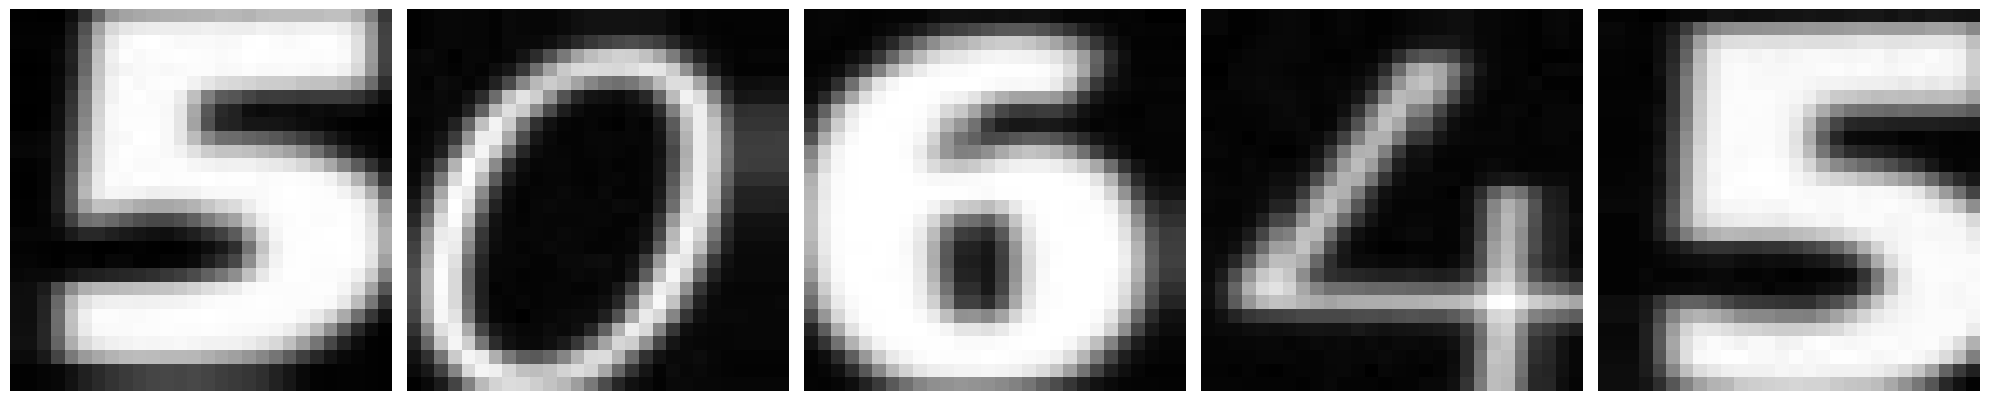

In [52]:
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:7], IMG_WIDTH, IMG_HEIGHT)

In [53]:
def create_callbacks():
    #Prepare call backs
    EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_WEIGHT_PATH, monitor = 'val_loss',
                                mode = 'min',save_best_only= True, save_weights_only=True)
    return [EarlyStop_callback, checkpoint]

In [54]:
def setup_optimizer():
    #lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    return SGD(learning_rate=0.01, momentum=MOMENTUM)

In [55]:
def fit_model(train_data_gen, val_data_gen):
    """ Fit SudokuNet """
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = setup_optimizer()
    model = SudokuNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth=1, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # define the callbacks
    my_callback = create_callbacks()

    if Path.exists(MODEL_WEIGHT_PATH):
        model.load_weights(MODEL_WEIGHT_PATH)
        history = None
    else:
        # train the network
        print("[INFO] training network...")
        history = model.fit(
            train_data_gen,
            steps_per_epoch=train_data_gen.samples // BS,
            epochs=EPOCHS,
            validation_data=val_data_gen,
            validation_steps=val_data_gen.samples // BS,
            callbacks = my_callback)

    return history, model

In [56]:
history, model = fit_model(train_data_gen=train_data_gen, val_data_gen=val_data_gen)

[INFO] compiling model...
[INFO] training network...
Epoch 1/50
143/143 [==============================] - 15s 97ms/step - loss: 2.1834 - accuracy: 0.1746 - val_loss: 1.5963 - val_accuracy: 0.4991
Epoch 2/50
143/143 [==============================] - 11s 78ms/step - loss: 1.4494 - accuracy: 0.4756 - val_loss: 0.2871 - val_accuracy: 0.9652
Epoch 3/50
143/143 [==============================] - 9s 65ms/step - loss: 0.8057 - accuracy: 0.7194 - val_loss: 0.0780 - val_accuracy: 0.9893
Epoch 4/50
143/143 [==============================] - 9s 65ms/step - loss: 0.5673 - accuracy: 0.8140 - val_loss: 0.0574 - val_accuracy: 0.9866
Epoch 5/50
143/143 [==============================] - 11s 74ms/step - loss: 0.4288 - accuracy: 0.8605 - val_loss: 0.0358 - val_accuracy: 0.9902
Epoch 6/50
143/143 [==============================] - 11s 75ms/step - loss: 0.3422 - accuracy: 0.8903 - val_loss: 0.0246 - val_accuracy: 0.9929
Epoch 7/50
143/143 [==============================] - 10s 73ms/step - loss: 0.3028 - 

In [57]:
def load_classifier_model():
    print("[INFO] loading model...")
    opt = setup_optimizer()
    model = SudokuNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth=1, classes=10)
    # model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.load_weights(MODEL_WEIGHT_PATH)
    return model

In [58]:
def evaluate_model_performance(generator, model):
    """ Evaluate model """
    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(generator)
    labels = generator.classes
    print(classification_report(
        labels,
        predictions.argmax(axis=1),
        target_names=[str(x) for x in range(10)]))

In [59]:
# For evaluation we need to create the generator new with 'shuffle=False'
train_data_gen = augmented_image_gen.flow_from_directory(batch_size=BS,
                                                     directory=OCR_DATASET_PATH / "training_data",
                                                     color_mode="grayscale",
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical")


Found 5730 images belonging to 10 classes.


In [61]:
model = load_classifier_model()
print("######### CLASSIFICATION REPORT ON TRAINING #########")
evaluate_model_performance(train_data_gen, model)
print("######### CLASSIFICATION REPORT ON TEST #########")
evaluate_model_performance(test_data_gen, model)

[INFO] loading model...
######### CLASSIFICATION REPORT ON TRAINING #########
[INFO] evaluating network...
180/180 [==============================] - 10s 57ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       573
           1       0.99      0.99      0.99       573
           2       1.00      1.00      1.00       573
           3       1.00      0.99      0.99       573
           4       1.00      1.00      1.00       573
           5       1.00      1.00      1.00       573
           6       1.00      1.00      1.00       573
           7       0.98      0.99      0.99       573
           8       1.00      1.00      1.00       573
           9       0.99      0.99      0.99       573

    accuracy                           1.00      5730
   macro avg       1.00      1.00      1.00      5730
weighted avg       1.00      1.00      1.00      5730

######### CLASSIFICATION REPORT ON TEST #########
[INFO] evaluating network..